In [1]:
import numpy as np
import pandas as pd 
import os
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
import sklearn.linear_model
from sklearn.utils import resample
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_sample_weight

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
# change os directory up one level
os.chdir(os.path.dirname(os.getcwd()))
from api_helpers.game_stats_helpers import load_past_n_games
# change os directory back 
os.chdir(os.path.join(os.getcwd(), 'selected_models'))

#print directory


## Data Preparation

In [11]:
def get_data():
    all_games_df = pd.read_csv("../data/all_games.csv",encoding="utf-8")
    all_games_df.drop("Unnamed: 0", axis=1,inplace=True)
    all_games_df = all_games_df.dropna()
    all_games_df = all_games_df[all_games_df['WL_A'] != ' ']
    X = all_games_df.drop(columns=["WL_A", "WL_B"])
    y = all_games_df["WL_A"]
    le = skp.LabelEncoder()
    y = le.fit_transform(y)
    return all_games_df, X, y

def data_prep(all_games_df, columns=["FG_PCT","FT_PCT", "OREB", "TOV", "DREB", "AST"]):
    columns_a = [column + "_A" for column in columns]
    columns_b = [column + "_B" for column in columns]

    n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns, n=20)
    n_games_df = n_games_df.dropna()

    x_columns = columns_a + columns_b
    y_column = "WL_A"

    #normalize x_data
    scaler = skp.StandardScaler()
    n_games_df[x_columns] = scaler.fit_transform(n_games_df[x_columns])
    # save scaler
    # joblib.dump(scaler, 'last20_scaler.bin')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(n_games_df[x_columns], n_games_df[y_column], test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [12]:
all_games_df, X,y = get_data()
print(all_games_df)

       SEASON_ID   TEAM_ID_A TEAM_ABBREVIATION_A        TEAM_NAME_A   GAME_ID  \
0          22023  1610612737                 ATL      Atlanta Hawks  22301159   
1          22023  1610612737                 ATL      Atlanta Hawks  22301147   
2          22023  1610612737                 ATL      Atlanta Hawks  22301104   
3          22023  1610612737                 ATL      Atlanta Hawks  22301076   
4          22023  1610612737                 ATL      Atlanta Hawks  22301060   
...          ...         ...                 ...                ...       ...   
52468      21996  1610612766                 CHH  Charlotte Hornets  29600141   
52469      21996  1610612766                 CHH  Charlotte Hornets  29600107   
52470      21996  1610612766                 CHH  Charlotte Hornets  29600064   
52471      21996  1610612766                 CHH  Charlotte Hornets  29600044   
52472      21996  1610612766                 CHH  Charlotte Hornets  29600016   

        GAME_DATE    MATCHU

## Feature Selection

In [5]:
# using Recursive Feature Elimination (RFE) to get best features
# Apply RFE
from sklearn.feature_selection import RFE
import sklearn.ensemble
import sklearn.linear_model

estimator = sklearn.ensemble.RandomForestRegressor() # using RandomForestRegressor is arbitrary, it worked better than logistic and linear
selector = RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(X, y)
selected_columns = X.columns[selector.support_]
selected_columns

       MIN_A  PTS_A  FGM_A  FGA_A  FG_PCT_A  FG3M_A  FG3A_A  FG3_PCT_A  FTM_A  \
0        240    114     43     82     0.524      18    40.0      0.450     10   
1        292    111     45    113     0.398      10    46.0      0.217     11   
2        240    121     49     90     0.544      13    38.0      0.342     10   
3        239    113     42     92     0.457      14    35.0      0.400     15   
4        265    123     51    104     0.490      15    44.0      0.341      6   
...      ...    ...    ...    ...       ...     ...     ...        ...    ...   
52468    240     93     33     75     0.440       4    10.0      0.400     23   
52469    240     87     34     89     0.382       7    22.0      0.318     12   
52470    240     98     33     68     0.485       5    16.0      0.313     27   
52471    239     88     33     80     0.413       5    17.0      0.294     17   
52472    241    109     39     81     0.481       7    17.0      0.412     24   

       FTA_A  ...  FT_PCT_B

KeyboardInterrupt: 

## Train Model

In [13]:
columns = ["PTS", "FG_PCT", "PLUS_MINUS", "DREB", "OREB", "TOV", "AST"]
X_train, X_test, y_train, y_test = data_prep(all_games_df, columns=columns)
print(X_train)
# logistic_model
lr_model = sklearn.linear_model.LogisticRegression()
param_grid = {
    'C': [0.05, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None]
    }
# grid search
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy', refit=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
lr_model = grid_search.best_estimator_
y_pred = lr_model.predict(X_test)

          PTS_A  FG_PCT_A  PLUS_MINUS_A    DREB_A    OREB_A     TOV_A  \
842   -0.427998 -0.301782     -1.002381 -1.443822 -0.200042  0.913695   
6956   0.531157 -0.301782     -1.831980  0.096984 -0.803901 -0.300209   
38626  1.000077  1.393855      1.790061  0.836571  0.317552 -0.673718   
27231 -0.108280  0.965073      0.949617 -0.827500 -0.631370 -0.486963   
50494 -1.706872 -0.646107     -0.324604 -0.580971 -0.890166  0.166677   
...         ...       ...           ...       ...       ...       ...   
23675  2.236322  0.939086      1.030950  2.500642  0.145021 -1.047226   
8671   1.383740  0.393364      0.434507  0.035352 -0.803901 -0.860472   
15402  0.701674  2.076008      1.085173 -1.074029 -0.200042 -0.113454   
865   -0.129594 -0.249808     -0.812603 -1.197293  1.352739 -0.580340   
22039 -0.278796  1.335385     -0.216159 -0.334442 -0.372573  1.567335   

          AST_A     PTS_B  FG_PCT_B  PLUS_MINUS_B    DREB_B    OREB_B  \
842   -0.751585  0.041649  0.499896      0.276782 

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.29      0.38      3067
           1       0.64      0.84      0.73      4522

    accuracy                           0.62      7589
   macro avg       0.60      0.57      0.55      7589
weighted avg       0.60      0.62      0.59      7589



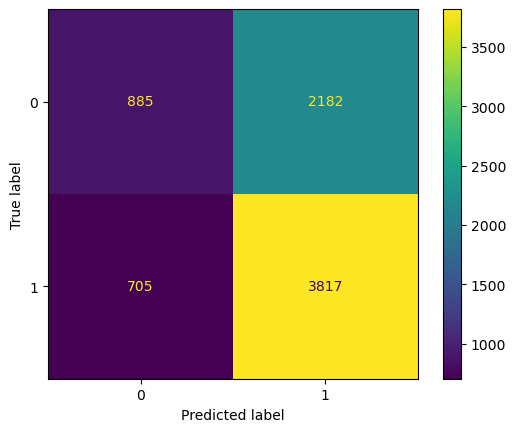

In [14]:
report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()